In [171]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
metaDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEn.csv", lineterminator="\n")

<ipython-input-3-42ae7f86572d>:1: DtypeWarning: Columns (6,7,8,12,20,49) have mixed types. Specify dtype option on import or set low_memory=False.
  metaDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEn.csv")


In [111]:
entDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/podIntroductions/floydMonth500wordNEs.csv", names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

In [132]:
descEntDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/NER/podDescriptions/floydMonthNEs.tsv", sep="\t",
                        names=["potentialOutPath", "ent", "start", "end", "type"], lineterminator="\n")

In [9]:
transcriptDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/allTranscripts.tsv", sep="\t", names=["potentialOutPath", "transcript"], lineterminator="\n")


## Clean Each Dataframe

In [12]:
metaDf.columns

Index(['Unnamed: 0', 'rssUrl', 'epTitle', 'epDescription', 'duration',
       'pubDate', 'copyright', 'itunes:type', 'itunes:complete', 'guid',
       'itunes:explicit', 'enclosure', 'itunes:image', 'transDict', 'id',
       'title', 'lastUpdate', 'link', 'lastHttpStatus', 'dead', 'contentType',
       'itunesId', 'originalUrl', 'itunesAuthor', 'itunesOwnerName',
       'explicit', 'imageUrl', 'itunesType', 'generator', 'newestItemPubdate',
       'language', 'oldestItemPubdate', 'episodeCount', 'popularityScore',
       'priority', 'createdOn', 'updateFrequency', 'chash', 'host',
       'newestEnclosureUrl', 'podcastGuid', 'podDescription', 'category1',
       'category2', 'category3', 'category4', 'category5', 'category6',
       'category7', 'category8', 'category9', 'category10',
       'newestEnclosureDuration', 'oldestItemDatetime', 'cleanDates',
       'potentialOutPath', 'cleanDatesLoc'],
      dtype='object')

In [19]:
metaNaNs = metaDf["itunesId"].isna()

In [23]:
#we have quite a few NaN values for itunesAuthor
metaDf.loc[metaNaNs].shape

(128233, 57)

In [24]:
guidNaNs = metaDf["guid"].isna()  

In [25]:
#we have only a tiny number of NaNs for guid
metaDf.loc[guidNaNs].shape

(644, 57)

In [28]:
#we appear to have *some* duplicates for guid 
#check if they're the same thing? 
sum(metaDf.duplicated(subset=["guid"])) #.shape 

37907

In [50]:
#rougly 68k duplicates on guid, which appear to truly be duplicates 
guidDups = metaDf.loc[metaDf.duplicated(subset=["guid"], keep=False)].sort_values("guid")[["guid", "epTitle", "epDescription", "potentialOutPath"]]

In [98]:
potOutDups = metaDf.loc[metaDf.duplicated(subset=["potentialOutPath"], keep=False)].sort_values("guid")[["guid", "epTitle", "epDescription", "potentialOutPath"]]

In [99]:
potOutDups.head() 

,guid,epTitle,epDescription,potentialOutPath
63686,https://indianapu...,"Harmonia Uncut: Viols, Vinci & Vittoria",Three strands are ...,/indianapublicmedia.org/oa/httpsindianapublicm...
363874,https://indianapu...,"Harmonia Uncut: Viols, Vinci & Vittoria",Three strands are ...,/indianapublicmedia.org/oa/httpsindianapublicm...
63685,https://indianapu...,Harmonia Uncut: Waltham Abbey 1993,The Waltham Abbey ...,/indianapublicmedia.org/ao/httpsindianapublicm...
363873,https://indianapu...,Harmonia Uncut: Waltham Abbey 1993,The Waltham Abbey ...,/indianapublicmedia.org/ao/httpsindianapublicm...
331476,https://www.astoriachu...,Created to Know God,NaN,/www.csmedia1.com/or/httpswww.csmedia1.comasto...


In [55]:
#we get some duplicates here on potentialOutPath
potOutDups.shape

(32296, 4)

In [56]:
#so about 15k are duplicates, not ideal but fine 
potOutDups.shape

(32296, 4)

In [64]:
metaDf.sample() 

,Unnamed: 0,rssUrl,epTitle,epDescription,duration,pubDate,copyright,itunes:type,itunes:complete,guid,...,category6,category7,category8,category9,category10,newestEnclosureDuration,oldestItemDatetime,cleanDates,potentialOutPath,cleanDatesLoc
322961,22462421,https://feeds.captivate.fm/hotyoungdesignersclub/,07: A Conversation With Lindsey Brooke,<p>This week the Hot Young Designers sit down ...,01:17:40,"Wed, 13 May 2020 06:00:00 -0700",NaN,NaN,NaN,00440d78-22e1-4ebd-aec4-b156d84b8782,...,self improvement,NaN,NaN,NaN,NaN,3886.0,2020-04-01 15:00:00,2020-05-13 06:00:00-07:00,/chtbl.com/a0/httpschtbl.comtrackDA1CA8podcast...,2020-05-13 13:00:00+00:00


In [65]:
transcriptDf[transcriptDf["potentialOutPath"].duplicated()].shape

(904, 2)

In [66]:
transcriptDf.shape

(377724, 2)

In [71]:
sum(transcriptDf["transcript"].isna())

1

In [82]:
lens = transcriptDf["transcript"].sample(5000).dropna().apply(lambda x: len(x.split())) 

<Axes: xlabel='transcript', ylabel='Proportion'>

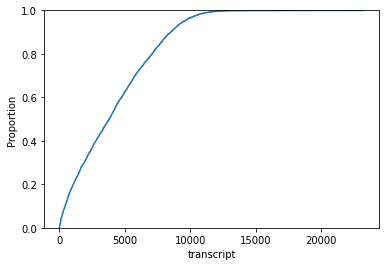

In [86]:
sns.ecdfplot(x=lens)

In [90]:
#first we just merge transcripts to metadata 
potOutDups = transcriptDf[transcriptDf["potentialOutPath"].duplicated(keep=False)].sort_values("potentialOutPath")

In [96]:
#it appears we do have some duplicate paths and transcripts? unclear exactly how this happened
#rare enough that we can ignore 
print(potOutDups.iloc[0, 1][:100])
print(potOutDups.iloc[1, 1][:100])

content The following is a continuation in our series through the seven letters to the churches of R
content The following is a continuation in our series through the seven letters to the churches of R


In [100]:
#de-duplicate rows in metadata 
metaDf = metaDf.drop_duplicates(subset=["potentialOutPath"]) 

In [102]:
transcriptDf = transcriptDf.drop_duplicates(subset=["potentialOutPath"])

In [119]:
metaDf["potentialOutPath"] = "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth" + metaDf["potentialOutPath"]

In [120]:
df = pd.merge(transcriptDf, metaDf, on="potentialOutPath", how="left") 

In [112]:
#add the entities in, but first check on duplicates 
entDf = entDf.groupby(by="potentialOutPath").agg(list)

In [126]:
entDf = entDf.reset_index() 

In [127]:
df = pd.merge(df, entDf, on="potentialOutPath", how="left") 

In [136]:
descEntDf = descEntDf.groupby(by="potentialOutPath").agg(list)

In [143]:
descEntDf = descEntDf.reset_index() 

In [144]:
descEntDf["potentialOutPath"] = "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth" + descEntDf["potentialOutPath"]

In [146]:
df.columns

Index(['potentialOutPath', 'transcript', 'Unnamed: 0', 'rssUrl', 'epTitle',
       'epDescription', 'duration', 'pubDate', 'copyright', 'itunes:type',
       'itunes:complete', 'guid', 'itunes:explicit', 'enclosure',
       'itunes:image', 'transDict', 'id', 'title', 'lastUpdate', 'link',
       'lastHttpStatus', 'dead', 'contentType', 'itunesId', 'originalUrl',
       'itunesAuthor', 'itunesOwnerName', 'explicit', 'imageUrl', 'itunesType',
       'generator', 'newestItemPubdate', 'language', 'oldestItemPubdate',
       'episodeCount', 'popularityScore', 'priority', 'createdOn',
       'updateFrequency', 'chash', 'host', 'newestEnclosureUrl', 'podcastGuid',
       'podDescription', 'category1', 'category2', 'category3', 'category4',
       'category5', 'category6', 'category7', 'category8', 'category9',
       'category10', 'newestEnclosureDuration', 'oldestItemDatetime',
       'cleanDates', 'cleanDatesLoc', 'ent', 'start', 'end', 'type'],
      dtype='object')

In [148]:
df = df.rename(columns={"ent":"500ent", "start":"500start", "end":"500end", "type":"500type"})

In [149]:
df = df.drop(columns=['Unnamed: 0']) 

In [155]:
descEntDf.head()

,potentialOutPath,ent,start,end,type
0,/shared/3/projects/benlitterer/podcastData/pro...,[TCF Sermons],[0],[11],[ORG]
1,/shared/3/projects/benlitterer/podcastData/pro...,"[KSCO Pet Radio's, Sundays 12-2 PM]","[0, 425]","[16, 440]","[ORG, DATE]"
2,/shared/3/projects/benlitterer/podcastData/pro...,"[the Truth of Jesus Christ, New Community Cove...","[17, 142, 172, 203, 213, 260, 293, 344, 392, 4...","[42, 171, 183, 210, 224, 289, 305, 356, 401, 4...","[WORK_OF_ART, ORG, GPE, GPE, GPE, ORG, FAC, PE..."
3,/shared/3/projects/benlitterer/podcastData/pro...,"[the Truth of Jesus Christ, New Community Cove...","[17, 142, 172, 203, 213, 260, 293, 344, 392, 4...","[42, 171, 183, 210, 224, 289, 305, 356, 401, 4...","[WORK_OF_ART, ORG, GPE, GPE, GPE, ORG, FAC, PE..."
4,/shared/3/projects/benlitterer/podcastData/pro...,"[the Truth of Jesus Christ, New Community Cove...","[17, 142, 172, 203, 213, 260, 293, 344, 392, 4...","[42, 171, 183, 210, 224, 289, 305, 356, 401, 4...","[WORK_OF_ART, ORG, GPE, GPE, GPE, ORG, FAC, PE..."


In [189]:
df = pd.merge(df, descEntDf, on="potentialOutPath", how="left") 

In [191]:
df = df.rename(columns={"ent":"DescEnt", "start":"DescStart", "end":"DescEnd", "type":"DescType"})

In [153]:
samp = df.sample(5000)

In [186]:
list(transcriptDf.sample(1)["transcript"])[0][:2000]

'content Alright" good morning. It is Friday and after the weekend I am taking Monday and Tuesday off of work. So this is exciting. It\'s been a while since I\'ve taken vacation when the factory\'s been open for more than just one day here and there. So I think I took one day back in January. It was a ton of fun because I happened to be sick during that time. So had a vacation day" it\'s gonna go and do some good fun stuff but then couldn\'t and it was a bummer. So I guess I\'m just hoping I don\'t get sick for my vacation days. But I\'m just pretty excited to not gonna really be doing anything. I\'m gonna be trying to get a haircut so that\'s kind of what the world has come to under COVID-19 is I gotta take two days off to go get a haircut. The bald look doesn\'t quite work for me. I got a misshapen head. I think I was dropped as a kid and that\'s either sparked genius or insanity but it does not lead to certain hairstyles. But today is the last day we are working the factory for the 

In [187]:
def cleanQuotes(inStr): 
    if inStr != inStr: 
        return inStr 
    outStr = re.sub('(?<!")"(?!")', ',',inStr) 
    return re.sub('"""', '"', outStr)

In [194]:
samp = samp["transcript"].apply(cleanQuotes)  

In [201]:
from tqdm import tqdm

In [221]:
outList = []
for i, row in tqdm(df.iterrows()): 
    outList.append(cleanQuotes(row["transcript"])[8:])

6853it [00:54, 125.04it/s]


KeyboardInterrupt: 

In [200]:
df["transcript"] = outList

KeyboardInterrupt: 

In [222]:
df.sample(5000).to_json("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthData.json", orient="records", lines=True)